The CIFAR-10 Problem Description

The problem of automatically identifying objects in photographs is difficult because of the near infinite number of permutations of objects, positions, lighting and so on. It’s a really hard problem.

This is a well studied problem in computer vision and more recently an important demonstration of the capability of deep learning. A standard computer vision and deep learning dataset for this problem was developed by the Canadian Institute for Advanced Research (CIFAR).

The CIFAR-10 dataset consists of 60,000 photos divided into 10 classes (hence the name CIFAR-10). Classes include common objects such as airplanes, automobiles, birds, cats and so on. The dataset is split in a standard way, where 50,000 images are used for training a model and the remaining 10,000 for evaluating its performance.

The photos are in color with red, green and blue components, but are small measuring 32 by 32 pixel squares.

State of the art results are achieved using very large Convolutional Neural networks. You can learn about state of the are results on CIFAR-10 on Rodrigo Benenson’s webpage. Model performance is reported in classification accuracy, with very good performance above 90% with human performance on the problem at 94% and state-of-the-art results at 96% at the time of writing.

There is a Kaggle competition that makes use of the CIFAR-10 dataset. It is a good place to join the discussion of developing new models for the problem and picking up models and scripts as a starting point.

In [1]:
#Import required libraries
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from urllib import urlretrieve
import cPickle as pickle
import os
import gzip
import numpy as np
import utils; reload(utils)
from scipy.misc import toimage
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Using Theano backend.


In [2]:
#Import Keras models
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras import backend as k
k.set_image_dim_ordering('th')

In [3]:
seed = 42
np.random.seed(42)

In [4]:
# load data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

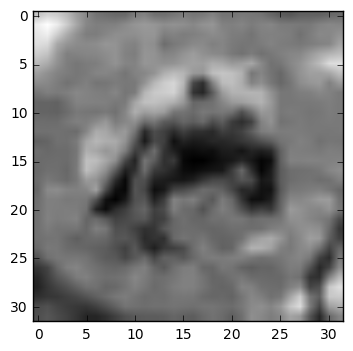

In [5]:
plt.imshow(X_train[0][0], cmap=cm.binary)

In [6]:
#Normalize input data
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

X_train = X_train/ 255.0
X_test = X_test / 255.0

In [7]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [8]:
num_classes = y_test.shape[1]

In [9]:
print num_classes

10


Larger Convolutional Neural Network for CIFAR-10

We have seen that a simple CNN performs poorly on this complex problem. In this section we look at scaling up the size and complexity of our model.

Let’s design a deep version of the simple CNN above. We can introduce an additional round of convolutions with many more feature maps. We will use the same pattern of Convolutional, Dropout, Convolutional and Max Pooling layers.

This pattern will be repeated 3 times with 32, 64, and 128 feature maps. The effect be an increasing number of feature maps with a smaller and smaller size given the max pooling layers. Finally an additional and larger Dense layer will be used at the output end of the network in an attempt to better translate the large number feature maps to class values.

We can summarize a new network architecture as follows:

Convolutional input layer, 32 feature maps with a size of 3×3 and a rectifier activation function.
Dropout layer at 20%.
Convolutional layer, 32 feature maps with a size of 3×3 and a rectifier activation function.
Max Pool layer with size 2×2.
Convolutional layer, 64 feature maps with a size of 3×3 and a rectifier activation function.
Dropout layer at 20%.
Convolutional layer, 64 feature maps with a size of 3×3 and a rectifier activation function.
Max Pool layer with size 2×2.
Convolutional layer, 128 feature maps with a size of 3×3 and a rectifier activation function.
Dropout layer at 20%.
Convolutional layer,128 feature maps with a size of 3×3 and a rectifier activation function.
Max Pool layer with size 2×2.
Flatten layer.
Dropout layer at 20%.
Fully connected layer with 1024 units and a rectifier activation function.
Dropout layer at 20%.
Fully connected layer with 512 units and a rectifier activation function.
Dropout layer at 20%.
Fully connected output layer with 10 units and a softmax activation function.
We can very easily define this network topology in Keras, as follows:

In [10]:
#create the model
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape = (3, 32, 32), 
                        activation='relu', border_mode='same'))
model.add(Dropout(0.2))
model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [11]:
#Compile the model
epochs = 2
lrate = 0.001
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 32, 32, 32)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 32, 32)    9248        dropout_1[0][0]                  
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 16, 16)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [12]:
#Fit the model
model.fit(X_train, y_train, validation_data = (X_test, y_test), nb_epoch = epochs, batch_size=64)
#Final evaluation of model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 474s - loss: 2.2988 - acc: 0.1054 - val_loss: 2.2975 - val_acc: 0.1203

Below are some ideas that you can try to extend upon the models and improve model performance.

Train for More Epochs. Each model was trained for a very small number of epochs, 25. It is common to train large convolutional neural networks for hundreds or thousands of epochs. I would expect that performance gains can be achieved by significantly raising the number of training epochs.

Image Data Augmentation. The objects in the image vary in their position. Another boost in model performance can likely be achieved by using some data augmentation. Methods such as standardization and random shifts and horizontal image flips may be beneficial.

Deeper Network Topology. The larger network presented is deep, but larger networks could be designed for the problem. This may involve more feature maps closer to the input and perhaps less aggressive pooling. Additionally, standard convolutional network topologies that have been shown useful may be adopted and evaluated on the problem.

In [13]:
preds = model.predict(X_test)

In [38]:
our_prediction = preds[:, 0]
our_labels = np.round(1 - our_prediction)
print our_labels

[ 1.  1.  1. ...,  1.  1.  1.]


In [37]:
print y_test[:5]

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]


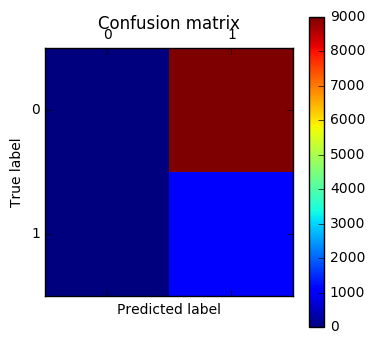

In [39]:
conf_matrix = confusion_matrix(y_test[:,0], our_labels)
plt.matshow(conf_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

[[   0 9000]
 [   0 1000]]


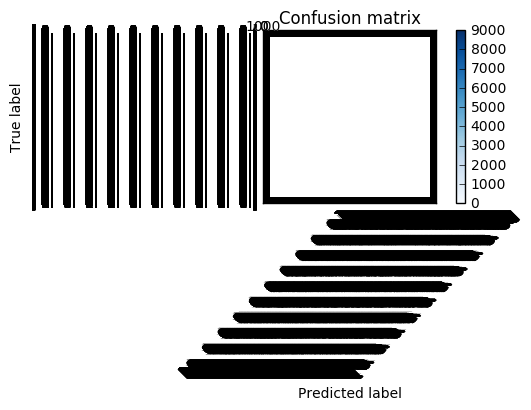

In [43]:
from utils import *
plot_confusion_matrix(conf_matrix, y_test)